In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models,preprocessing
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 4
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory='riceleaf',
shuffle = True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 119 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print("Image Batch Shape : ", image_batch.shape)
    print("Single Image : ", image_batch[0])
    print("Label Image numpy : ", label_batch.numpy)

Image Batch Shape :  (4, 255, 255, 3)
Single Image :  tf.Tensor(
[[[238.88124 230.88124 227.88124]
  [238.90256 231.3445  225.62354]
  [238.29411 234.34048 229.8173 ]
  ...
  [238.      231.      225.     ]
  [236.90256 227.90256 222.90256]
  [237.45874 230.45874 222.45874]]

 [[239.35626 231.35626 228.35626]
  [237.      232.      226.     ]
  [240.      232.      229.     ]
  ...
  [238.      231.      225.     ]
  [237.      227.      225.     ]
  [237.22353 228.22353 221.22353]]

 [[240.      233.      227.     ]
  [237.      234.      229.     ]
  [241.49828 232.49828 227.49828]
  ...
  [237.29395 230.29395 224.29395]
  [237.      227.      225.     ]
  [236.54126 225.54126 219.54126]]

 ...

 [[238.      231.      223.     ]
  [238.70587 230.29413 221.     ]
  [237.99998 229.58824 220.29411]
  ...
  [238.1731  229.1731  222.1731 ]
  [238.      229.      222.     ]
  [238.61794 231.61794 223.61794]]

 [[238.22351 230.77649 223.     ]
  [239.      230.      221.     ]
  [238.29411 

In [6]:
len(class_names)

3

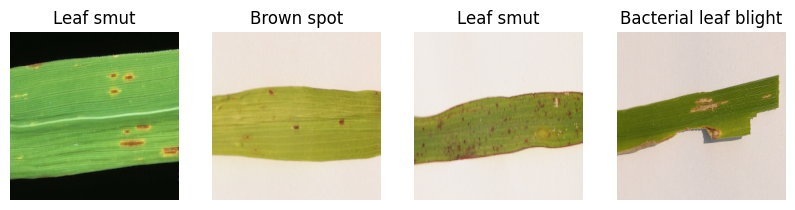

In [41]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

30

In [9]:
train_size = 0.8
len(dataset) * train_size


24.0

In [10]:
train_ds = dataset.take(24)
len(train_ds)

24

In [11]:
test_ds = dataset.skip(24)
len(test_ds)

6

In [12]:
val_size = 0.1
len(dataset)*val_size

3.0

In [13]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [14]:
test_ds = test_ds.skip(3)
len(test_ds)

3

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
from tensorflow.keras.layers import Resizing,Rescaling,RandomFlip,RandomRotation

In [18]:
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([RandomFlip("horizontal_and_vertical"),RandomRotation(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
inputs=Input(shape=input_shape)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
 
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Nithish\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (4, 255, 255, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (4, 253, 253, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (4, 126, 126, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (4, 124, 124, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (4, 62, 62, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (4, 60, 60, 64)             │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (4, 30, 30, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (4, 57600)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (4, 64)                     │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (4, 3)                      │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,742,979 (14.28 MB)

 Trainable params: 3,742,979 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])


In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 980ms/step - accuracy: 0.2817 - loss: 1.2025 - val_accuracy: 0.4167 - val_loss: 1.0789
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 754ms/step - accuracy: 0.3678 - loss: 1.0802 - val_accuracy: 0.4167 - val_loss: 1.1242
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 716ms/step - accuracy: 0.4684 - loss: 1.1202 - val_accuracy: 0.5833 - val_loss: 1.0599
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 702ms/step - accuracy: 0.4567 - loss: 1.0559 - val_accuracy: 0.5833 - val_loss: 0.9253
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 650ms/step - accuracy: 0.6022 - loss: 0.9187 - val_accuracy: 0.4167 - val_loss: 1.2276
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 675ms/step - accuracy: 0.5183 - loss: 0.9948 - val_accuracy: 0.6667 - val_loss: 0.7771
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 681ms/step - accuracy: 0.5498 - loss: 0.9896 - val_accuracy: 0.6667 - val_loss: 0.6463
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 652ms/step - accuracy: 0.7135 - loss: 0.7720 - val_accu

In [25]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.7386 - loss: 0.6681


In [26]:
model.save("model.h5")

In [27]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 20, 'steps': 24}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [28]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.148622989654541,
 1.0733072757720947,
 1.060295820236206,
 1.0748592615127563,
 0.9293291568756104]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


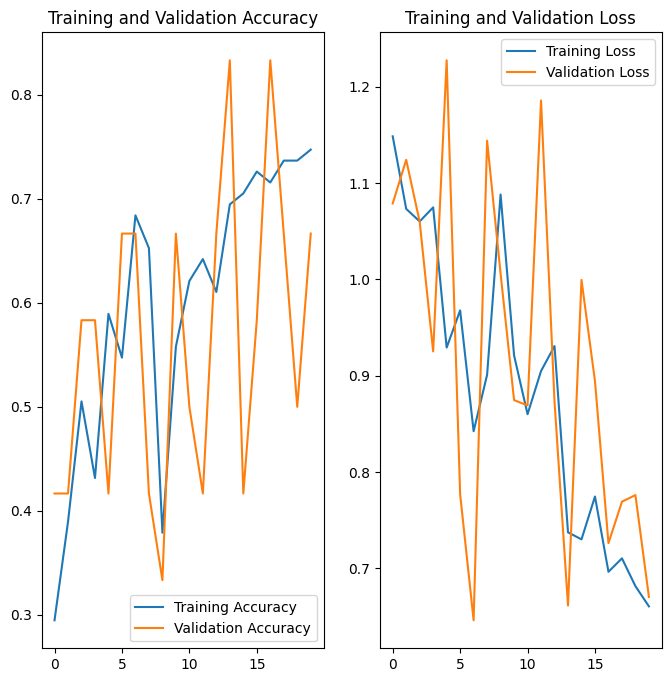

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
model = tf.keras.models.load_model('model.h5')

In [32]:

#import numpy as np
#for images_batch, labels_batch in test_ds.take(1):
    
 #   first_image = images_batch[0].numpy().astype('uint8')
  #  first_label = labels_batch[0].numpy()
    
   ##plt.imshow(first_image)
    #print("actual label:",class_names[first_label])
    
    #batch_prediction = model.predict(images_batch)
    #print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


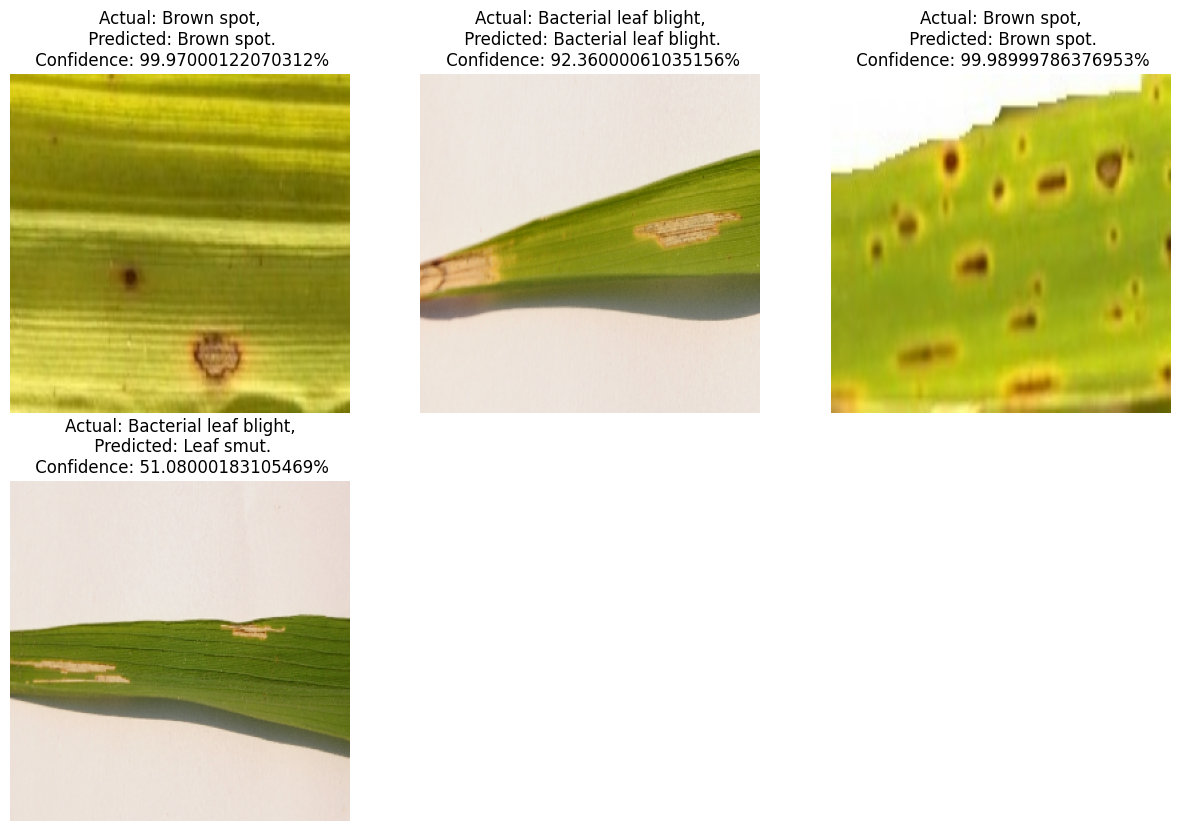

In [38]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
